In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename
from AD5764 import Arduino

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})

Could not import QickSoc: No module named 'pynq'


C:\Users\slab\anaconda3\envs\py37vis\lib\site-packages\visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,
C:\Users\slab\anaconda3\envs\py37vis\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

experiments.amplitude_rabi
experiments.amplitude_rabi_ef
experiments.length_rabi
experiments.pulse_probe_ef_spectroscopy
experiments.pulse_probe_spectroscopy
experiments.ramsey_ef
experiments.resonator_spectroscopy
experiments.rfsoc_tof_calibration
experiments.single_shot
experiments.t1
experiments.t2_echo
experiments.t2_ramsey


In [3]:
expt_path=os.getcwd()+'\data'
print('Data will be stored in', expt_path)
config_path = os.getcwd() + '\config.yml'
print('Config will be', config_path)

Data will be stored in s:\Connie\experiments\20220222_LL_flux_crosstalk\data
Config will be s:\Connie\experiments\20220222_LL_flux_crosstalk\config.yml


In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
    return temp_data

In [5]:
qubit_i = 3 # which qubit/resonator we want to probe

qubit_to_dac = [2, 4, 1, 3]
dc_ch = qubit_to_dac[qubit_i]
# dc_ch = 2
print(f'Using DAC box ch {dc_ch} with qubit {qubit_i}')

Using DAC box ch 3 with qubit 3


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [13]:
import yaml
with open('config.yml', 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)

In [14]:
im = InstrumentManager()

lo1 = im[yaml_cfg['aliases']['readout_LO']]
lo1.open_device()
# lo1.set_standby(True)
# lo1.set_output_state(False) # TURN ON/OFF
lo1.set_standby(False)
lo1.set_output_state(True) # TURN ON/OFF

lo1.set_frequency(float(yaml_cfg['hw']['lo']['readout']['frequency'])) # Set LO frequency
lo1.set_power(float(yaml_cfg['hw']['lo']['readout']['power'])) # Set LO power

0

In [22]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
# print(soc.description())

In [14]:
arduino = Arduino(port='COM9')

In [13]:
# arduino.close()

In [238]:
# arduino.initialize() # set everything to 0
# arduino.set_voltage(channel=dc_ch, voltage=0.012)
arduino.set_voltage(channel=qubit_to_dac[qubit_i], voltage=2e-3)
# arduino.set_voltage(channel=1, voltage=0)

Set ch 2 to 0.002 volts


In [239]:
# Clara the PNAX
# pnax = im['PNAX']
# print(f'{pnax.get_id()}')

yoko = im['YOKO2']
print(f'{yoko.get_id()}')

YOKOGAWA,GS210,91NB10941,2.01


In [248]:
# yoko.set_mode('VOLT')
# yoko.set_voltage_limit(1)
# print('volt limit', yoko.get_voltage_limit())

yoko.set_mode('CURR')
yoko.set_current_limit(10e-3)
yoko.set_range(10e-3)
print(f'current limit {yoko.get_current_limit()*1e6} uA')
print(f'current range {yoko.get_range()*1e6} uA')

yoko.set_output(False)

current limit 10000.0 uA
current range 10000.0 uA


In [253]:
# yoko.set_volt(60e-3)
yoko.set_current(-2e-3)

yoko.set_output(True)
time.sleep(3)
# print(f'volt set to {yoko.get_volt() * 1e3} mV')
print(f'current set to {yoko.get_current() * 1e6} uA')

current set to -2000.0 uA


# RFSoC Calibration

If the RFSoC is power cycled first run "dac-adc phase offset" calibration.

Run this calibration when the wiring of the setup is changed.

This calibration measures the time of flight of measurement pulse so we only start capturing data from this point in time onwards. Time of flight (tof) is stored in parameter <code>cfg.device.readout.trig_offset</code>.

In [338]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=2, # [us]
    gain=20000, # [DAC units]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    adc_trig_offset=0, # [Clock ticks]
    reps=5000, # Number of averages per point
    qubit_i=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.01 # wait time between experiments [us]
print(tof.cfg)
tof.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [50, 50, 50, 50], 'f_ge': [4030.32, 4192, 4100, 4100], 'f_ef': [4000, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [10000, 32000, 10000, 10000], 'sigma': [0.1, 4.0, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.5, 1821.67, 1940, 2055], 'gain': [1000, 110, 1000, 1000], 'phase': [0, 0, 0, 0], 'readout_length': 2, 'relax_delay': 0.01}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C6', 'soc': 'Qick187'}, 'expt': {'pulse_length': 0.5, 'readout_length': 2, 'gain': 20000, 'frequency': 1821.67, '

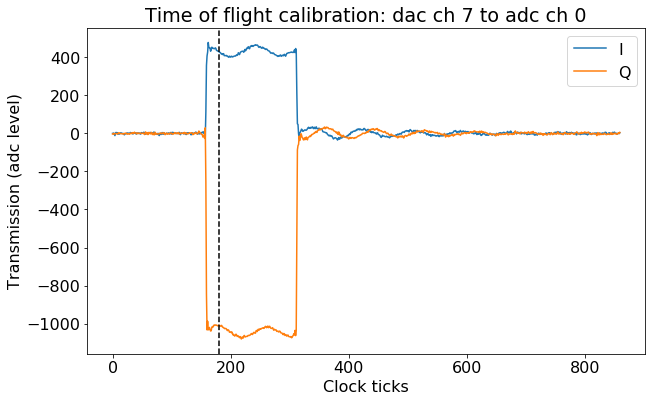

In [339]:
tof.display(adc_trig_offset=180)

In [131]:
tof.save_data()

Saving s:\Connie\experiments\202201xx_2Transmon_Connie/data\00000_adc_trig_offset_calibration_qubit1.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [23]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 4 # MHz
npts = 151
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    # start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    start=1940,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=3000, # Number averages per point
    pi_pulse=False, # add pi pulse prior to measurement
    qubit=qubit_i,
)
rspec.cfg.device.readout.relax_delay=1 # Wait time between experiments [us]
rspec.cfg.device.readout.readout_length=2 # For some reason it doesn't like it when this is more than 1-2 [us]

# print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

-- Fit Result --
f0: 1942.5371490953214
Qi: -10177.387124837855
Qc: 4408.721420814974
df: -0.009664851741560869
Scale: 4.398284174440598
Q: 7778.101024975118
kappa [MHz]: 0.2497443968467272


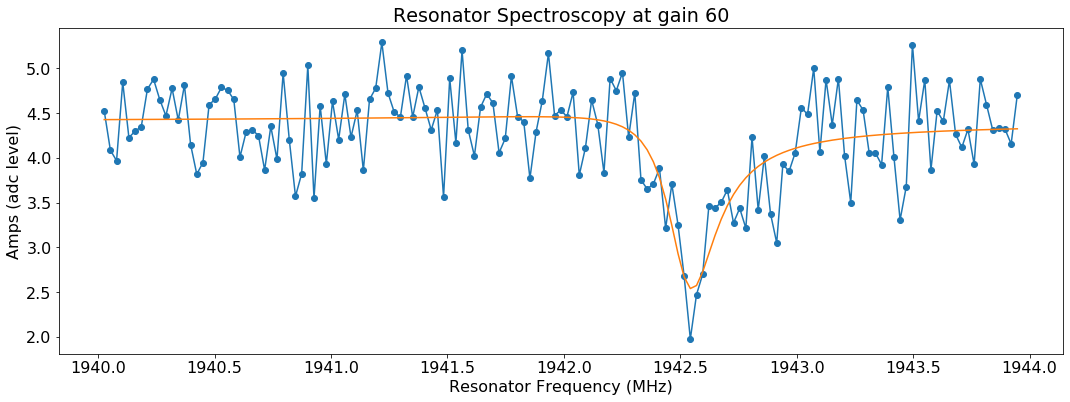

In [280]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=True, findpeaks=False)

In [313]:
rspec.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00010_resonator_spectroscopy_qubit1.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [12]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 3.0
npts_f = 5

span_gain = 1000
npts_gain = 10

rpowspec.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # Resonator frequency to be mixed up [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10, # Number averages per point
    pi_pulse=False, # add pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1], 'T1': [130, 45], 'f_ge': [3672.7788, 4565.7], 'f_ef': [3513.592, 4387.126], 'pulses': {'pi_ge': {'gain': [20522, 2012], 'sigma': [0.1, 0.05], 'type': 'gauss'}, 'pi_ef': {'gain': [7195, 1590], 'sigma': [0.3, 0.05], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1], 'adc': [0, 1], 'lo': ['readout', 'readout'], 'trig_offset': 250, 'frequency': [299.6865, 899.6655], 'gain': [60, 120], 'phase': [0, 0.49892147931760106], 'readout_length': 10, 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '6.25e9', 'power': 16}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [4, 5], 'nyquist': [2, 2]}, 'readout': {'ch': [7, 1], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start_f': 297.4365, 'step_f': 0.6, 'expts_f': 5, 'start_gain': 0, 'step_gain': 100, 'expts_gain': 10, 'reps': 10, 'pi_pulse': False, 'qubit': 0}}


High power peak [MHz]: 299.83705774332196
Low power peak [MHz]: 299.8361175848374
Lamb shift [MHz]: 0.0009401584845818434


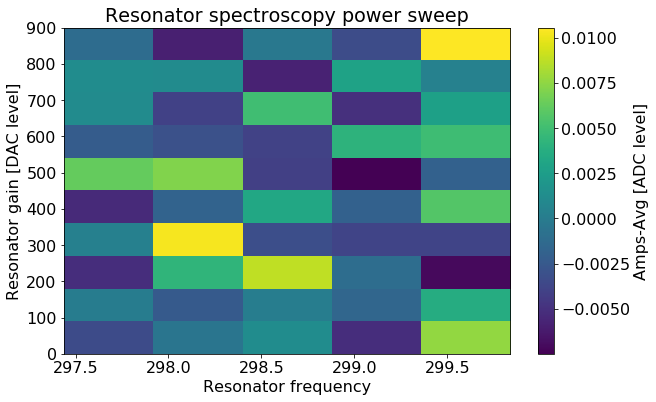

In [13]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     keys = list(a)
#     temp_data = dict()
#     for key in keys:
#         temp_data.update({key:np.array(a[key])})

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

rpowspec.analyze(lowgain=None, highgain=None)
rpowspec.display()

In [276]:
rpowspec.save_data()

Saving s:\Connie\experiments\202201xx_2Transmon_Connie/data\00000_power_sweep_resonator_spectroscopy_qubit1.h5


## Voltage sweep resonator spectroscopy

In [285]:
rvoltspec = meas.ResonatorVoltSweepSpectroscopyExperiment(
    soccfg=soc,
    # dc_instr=arduino,
    dc_instr=yoko,
    path=expt_path,
    prefix=f"voltage_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 4
npts_f = 151

span_volt = 4e-3
npts_volt = 61

rvoltspec.cfg.expt = dict(
    dc_ch=qubit_to_dac[qubit_i],
    start_f=2055.5, #rvoltspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Resonator frequency to be mixed up [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_volt=-2e-3, #span_volt/2,
    step_volt=span_volt/npts_volt, # Gain step size
    expts_volt=npts_volt, # Number experiments stepping gain from start
    reps=3000, # Number averages per point
    pi_pulse=False, # add pi pulse before measurement
    qubit=qubit_i,
)
rvoltspec.cfg.device.readout.relax_delay = 3 # Wait time between experiments [us]
rvoltspec.cfg.device.readout.readout_length=2 # For some reason it doesn't like it when this is more than 1-2 [us]

print(rvoltspec.cfg)

rvoltspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4318.128165137126, 4200.120666612184, 4332.61700737276, 4235.7], 'dc_offset': [-0.0026, 0.00255, '2e-3', '5e-3'], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.7976311472094, 1943.3427763118934, 2058.56], 'gain': [70, 50, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 2, 'relax_delay': 3}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C

current set to -2000.0 uA
current set to -1934.3999999999999 uA
current set to -1868.8000000000002 uA
current set to -1803.2 uA
current set to -1737.7 uA
current set to -1672.1 uA
current set to -1606.5 uA
current set to -1540.9 uA
current set to -1475.3999999999999 uA
current set to -1409.8 uA
current set to -1344.2 uA
current set to -1278.6 uA
current set to -1213.1 uA
current set to -1147.5 uA
current set to -1081.9 uA
current set to -1016.3 uA
current set to -950.8000000000001 uA
current set to -885.2 uA
current set to -819.6 uA
current set to -754.0 uA
current set to -688.5 uA
current set to -622.9 uA
current set to -557.3000000000001 uA
current set to -491.8 uA
current set to -426.2 uA
current set to -360.59999999999997 uA
current set to -295.0 uA
current set to -229.5 uA
current set to -163.9 uA
current set to -98.3 uA
current set to -32.7 uA
current set to 32.7 uA
current set to 98.3 uA
current set to 163.9 uA
current set to 229.5 uA
current set to 295.0 uA
current set to 360.5

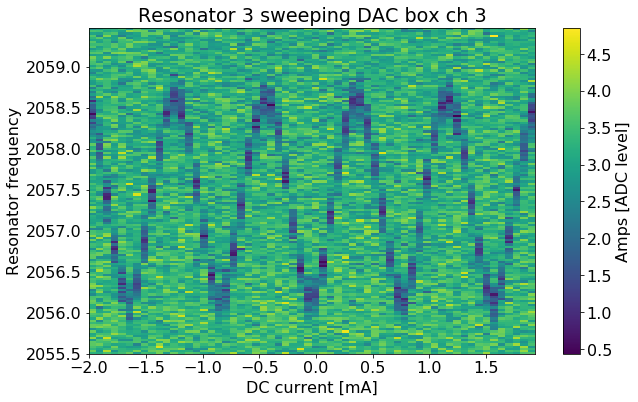

In [286]:
# TESTING
# temp_data = prev_data(expt_path, '00024_voltage_sweep_resonator_spectroscopy_qubit0.h5')
# add_data = []
# add_data.append(prev_data(expt_path, '00025_voltage_sweep_resonator_spectroscopy_qubit0.h5'))
# add_data.append(prev_data(expt_path, '00026_voltage_sweep_resonator_spectroscopy_qubit0.h5'))
# data = rvoltspec.analyze(data=temp_data)
# rvoltspec.display(data=temp_data, add_data=add_data)

rvoltspec.analyze()
rvoltspec.display()

In [287]:
rvoltspec.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00006_voltage_sweep_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [230]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 70
npts = 100

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=3000,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=1000, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=1000, # Qubit pulse gain
    qubit=qubit_i,
    # frequency=1821.6 #from res spec above
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time betwee n experiments [us]

# print(qspec.cfg)

# arduino.set_voltage(channel=dc_ch, voltage=0.2)
qspec.go(analyze=False, display=False, progress=True, save=False)
# arduino.set_voltage(channel=dc_ch, voltage=0)

# qspec.analyze(fit=True)
# qspec.display(fit=True)

Found peak in I at [MHz] 4198.505057294696, HWHM 2.629947538998101
Found peak in Q at [MHz] 4198.030329514131, HWHM 3.430668439957543


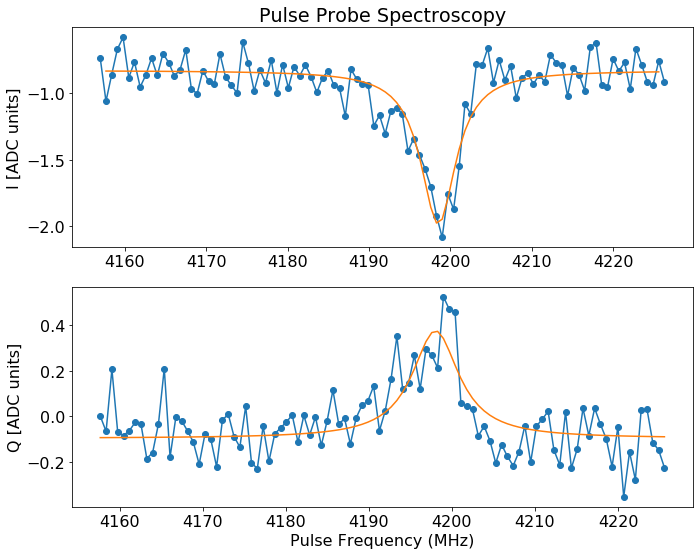

In [231]:
# TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data)

qspec.analyze(fit=True)
qspec.display(fit=True)

In [752]:
qspec.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00002_qubit_spectroscopy_qubit3.h5


## Voltage sweep qubit spectroscopy

In [220]:
qvoltspec = meas.PulseProbeVoltSweepSpectroscopyExperiment(
    soccfg=soc,
    dc_instr=arduino,
    path=expt_path,
    prefix=f"voltage_sweep_qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_qf = 400 # MHz
npts_qf = 800

span_rf = 1.5 # MHz
npts_rf = 150

span_volt = 6e-3
npts_volt = 20

qvoltspec.cfg.expt = dict(
    start_qf=3900, # qubit freq [MHz]
    step_qf=span_qf/npts_qf,
    expts_qf=npts_qf,
    length=10, # qubit probe const pulse length [us]
    gain=1000, # qubit pulse gain [DAC units]
    dc_ch=qubit_to_dac[qubit_i], # channel to sweep voltage
    # dc_ch=qubit_to_dac[1],

    start_rf=1821,
    step_rf=span_rf/npts_rf,
    expts_rf=npts_rf,

    start_volt=0e-3,
    step_volt=span_volt/npts_volt, # Gain step size
    expts_volt=npts_volt, # Number experiments stepping gain from start

    reps_q=500, # Number averages per point for qubit spectroscopy
    rounds_q=20,

    reps_r=2000, # Num averages per point for resonator spec
    qubit=qubit_i,
)
qvoltspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]

print(qvoltspec.cfg)

qvoltspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4318.128165137126, 4191.984114930232, 4332.61700737276, 4235.7], 'dc_offset': [-0.0026, '3e-3', '2e-3', '5e-3'], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.792, 1943.3427763118934, 2058.56], 'gain': [40, 70, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 5, 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C6', 'soc':

Set ch 4 to 0.0 volts
readout at 1821.434686552981 at voltage 0.0
Set ch 4 to 0.00030000000000000003 volts
readout at 1821.5084060297852 at voltage 0.00030000000000000003
Set ch 4 to 0.0006000000000000001 volts
readout at 1821.588413471122 at voltage 0.0006000000000000001
Set ch 4 to 0.0009000000000000001 volts
readout at 1821.650367247034 at voltage 0.0009000000000000001
Set ch 4 to 0.0012000000000000001 volts
readout at 1821.7000322765061 at voltage 0.0012000000000000001
Set ch 4 to 0.0015 volts
readout at 1821.7444485358378 at voltage 0.0015
Set ch 4 to 0.0018000000000000002 volts
readout at 1821.7756478188967 at voltage 0.0018000000000000002
Set ch 4 to 0.0021000000000000003 volts
readout at 1821.7976834733765 at voltage 0.0021000000000000003
Set ch 4 to 0.0024000000000000002 volts
readout at 1821.8102686887992 at voltage 0.0024000000000000002
Set ch 4 to 0.0027 volts
readout at 1821.806443782794 at voltage 0.0027
Set ch 4 to 0.003 volts
readout at 1821.782861246252 at voltage 0.00

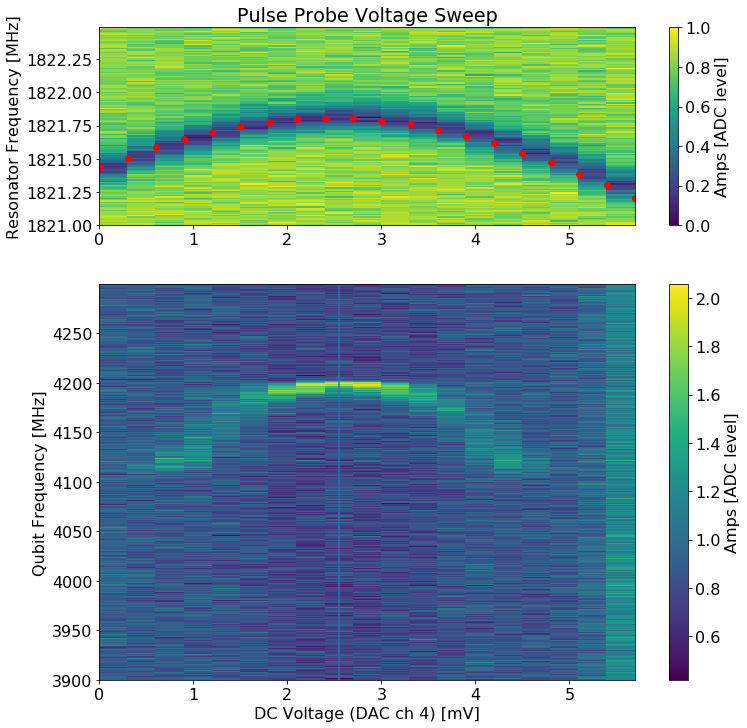

In [225]:
# TESTING
# temp_data = prev_data(expt_path, '00002_voltage_sweep_qubit_spectroscopy_qubit0.h5')
# add_data = []
# add_data.append(prev_data(expt_path, '00003_voltage_sweep_qubit_spectroscopy_qubit0.h5'))
# add_data.append(prev_data(expt_path, '00007_voltage_sweep_qubit_spectroscopy_qubit0.h5'))
# add_data.append(prev_data(expt_path, '00005_voltage_sweep_qubit_spectroscopy_qubit0.h5'))
# data = qvoltspec.analyze(data=temp_data, lowgain=2000, highgain=18000)
# qvoltspec.display(data=temp_data, add_data=add_data)

qvoltspec.analyze()
qvoltspec.display()

In [222]:
qvoltspec.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00000_voltage_sweep_qubit_spectroscopy_qubit1.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [17]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=soc.cycles2us(5), # pulse length (sigma) [us]
    step=soc.cycles2us(2), # [us]
    # step=0.001,
    expts=101,
    reps=5000,
    rounds=1,
    gain=32000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubit=qubit_i,
)
lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4318.128165137126, 4200.120666612184, 4332.61700737276, 4235.7], 'dc_offset': [-0.0026, 0.00255, '2e-3', '5e-3'], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.7976311472094, 1943.3427763118934, 2058.56], 'gain': [70, 50, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 5, 'relax_delay': 50}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [4, 4, 4, 4], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [6, 6, 6, 6], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26

TypeError: 'Proxy' object is not subscriptable

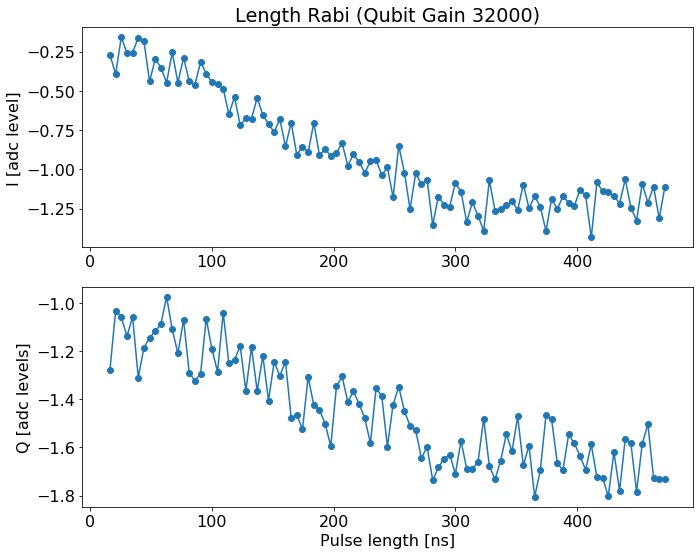

In [693]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=False)
lengthrabi.display(fit=False)

In [691]:
lengthrabi.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00000_length_rabi_qubit3.h5


## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [243]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 200
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=200,
    rounds=20,
    sigma_test=0.200, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabi.cfg)

amprabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4315.072919133881, 4191.984114930232, 4332.61700737276, 4235.7], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.792, 1943.3427763118934, 2058.56], 'gain': [50, 70, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 5, 'relax_delay': 50}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C6', 'soc': 'Qick187'}, 'expt': {'start': 0, 'step': 160, '


200 200
0.6345032148283591 8.276758752695763


Pi gain from avgi data [dac units]: 10891
Pi/2 gain from avgi data [dac units]: 5445
Pi gain from avgq data [dac units]: 14640
Pi/2 gain from avgq data [dac units]: 7320


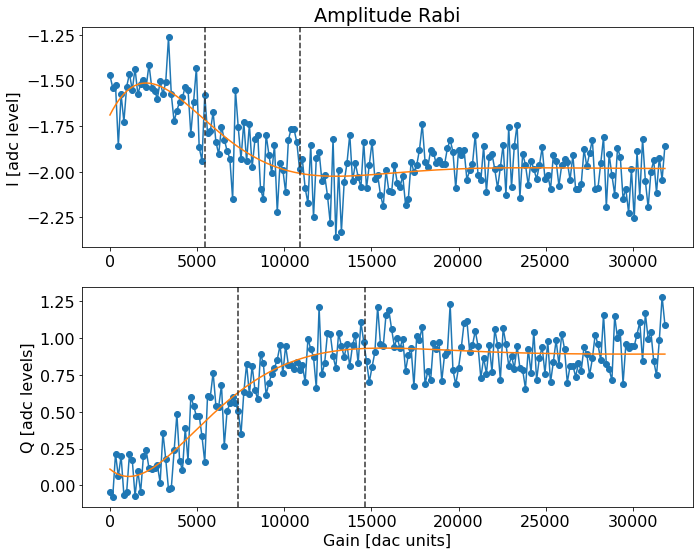

In [245]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = amprabi.analyze(data=temp_data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [762]:
amprabi.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00000_amp_rabi_qubit3.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [290]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

span_gain = 32000
npts_gain = 51

span_f = 5
npts_f = 30

amprabichev.cfg.expt = dict(
    start_f=4315,
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=0, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=500,
    rounds=10,
    sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 50, 50], 'f_ge': [4317.568859135685, 4191.984114930232, 4100, 4100], 'f_ef': [4000, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [11000, 11126, 10000, 10000], 'sigma': [0.2, 0.1, 0.1, 0.1], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.6, 1821.77, 1940, 2055], 'gain': [100, 70, 100, 1000], 'phase': [0, 0, 0, 0], 'readout_length': 2, 'relax_delay': 50}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C6', 'soc': 'Qick187'}, 'expt': {'start_f': 4315, 'step_f': 0.1666

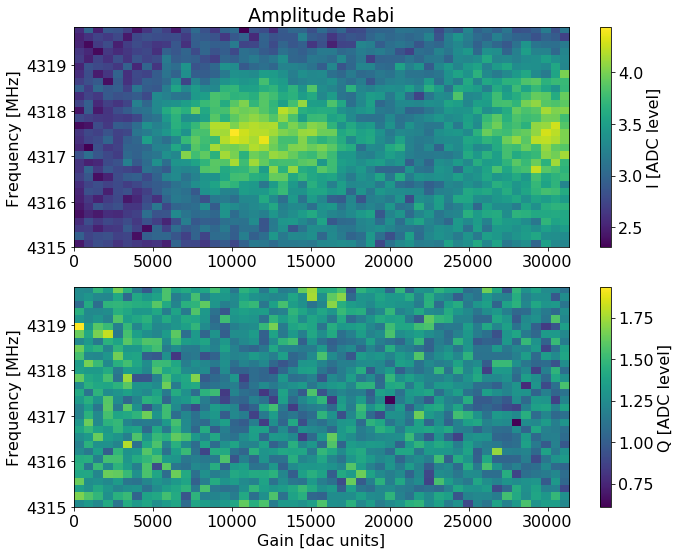

In [291]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [292]:
amprabichev.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00000_amp_rabi_qubit_chevron0.h5


## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [250]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=50000,
    qubit=qubit_i,
)

# shot.cfg.device.readout.readout_length = 10 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]

print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4315.072919133881, 4191.984114930232, 4332.61700737276, 4235.7], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.792, 1943.3427763118934, 2058.56], 'gain': [50, 70, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 5, 'relax_delay': 70}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C6', 'soc': 'Qick187'}, 'expt': {'reps': 50000, 'qubit': 0}

Ig -1.610232558139535 Ig std dev 8.186839611832529 Ie -1.9537209302325582 Qg 0.016046511627906976 Qe 0.8783720930232559
Ig 0.6054571315994248 Ig std dev 8.186839611832529 Ie 1.5625601333685846 Qg 1.4803218497867778 Qe 1.50667227219115
Ig -1.610232558139535 Ig std dev 8.186839611832529 Ie -1.9537209302325582 Qg 0.016046511627906976 Qe 0.8783720930232559
Ig 0.6054571315994248 Ig std dev 8.186839611832529 Ie 1.5625601333685846 Qg 1.4803218497867778 Qe 1.50667227219115
fidelity: 0.046912197171264526
angle: -1.9498604419501837
threshold: 1.5054571315994245


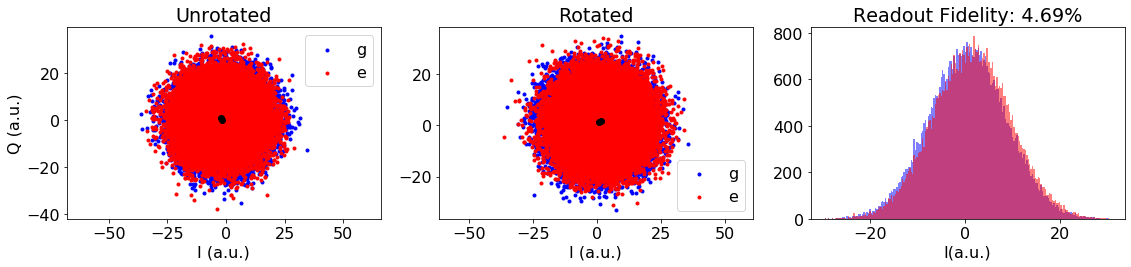

In [251]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = shot.analyze(data=temp_data, fit=True)

shot.analyze(fit=True)
shot.display(span=30)

In [765]:
shot.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00000_single_shot_qubit3.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [769]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 100
npts = 201

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=1000,
    rounds=10,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 50, 50], 'f_ge': [4317.299006613412, 4191.984114930232, 4332.61700737276, 4236], 'f_ef': [4000, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.77, 1943.3427763118934, 2058.56], 'gain': [120, 70, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 5, 'relax_delay': 100}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C6', 'soc': 'Qick187'}, 'e

Fit T1 [us]: 22.606543812364844


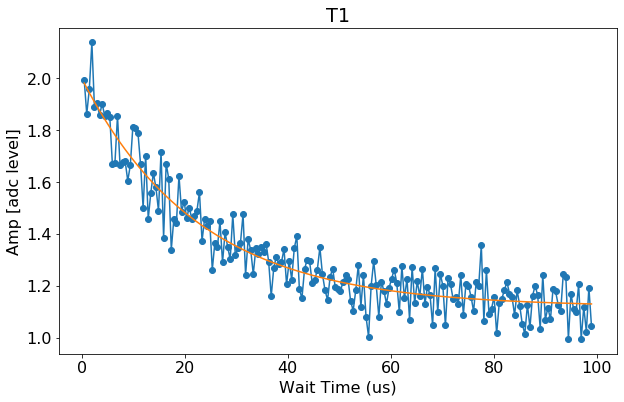

In [770]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = t1.analyze(data=temp_data, fit=True)

t1.analyze(fit=True)
t1.display()

In [771]:
t1.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00000_t1_qubit3.h5


## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [232]:
0.5/soc.cycles2us(1)

215.04

In [236]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=401,
    ramsey_freq=3, # [MHz]
    reps=1000,
    rounds=20,
    qubit=qubit_i,
)

t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2r.cfg)

t2r.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4318.128165137126, 4200.120666612184, 4332.61700737276, 4235.7], 'dc_offset': [-0.0026, 0.00255, '2e-3', '5e-3'], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.7976311472094, 1943.3427763118934, 2058.56], 'gain': [40, 70, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 5, 'relax_delay': 84}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26

Fit frequency from I [MHz]: 3.0057227689878827
Suggested new qubit frequency from fit I [MHz]: 4200.114943843197
T2 Ramsey from fit I [us]: 0.2644303015423608
Fit frequency from Q [MHz]: 3.0279718081241804
Suggested new qubit frequency from fit Q [MHz]: 4200.092694804061
T2 Ramsey from fit Q [us]: 0.3087074210872771


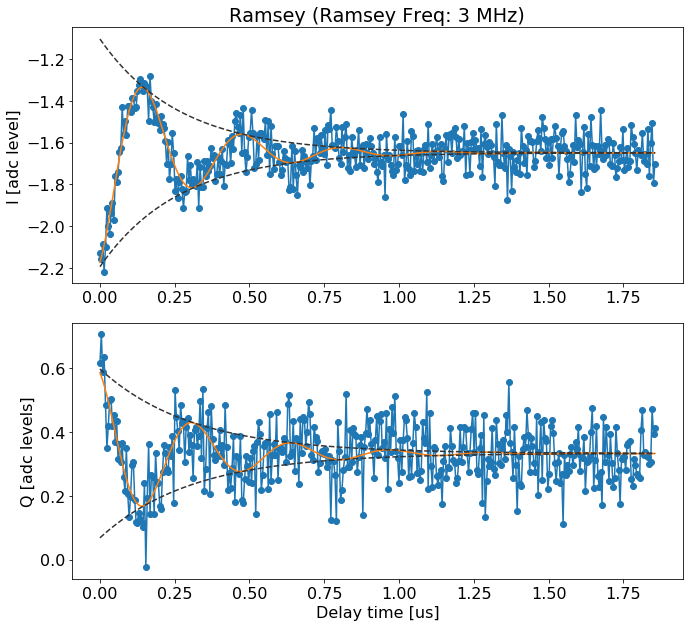

In [237]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = t2r.analyze(data=temp_data, fit=True)

t2r.analyze(fit=True)
t2r.display(fit=True)

In [238]:
t2r.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00001_ramsey_qubit1.h5


## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [117]:
soc.us2cycles(0.005)

2

In [239]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(2), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=401,
    ramsey_freq=3, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=1000,
    rounds=20,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4318.128165137126, 4200.120666612184, 4332.61700737276, 4235.7], 'dc_offset': [-0.0026, 0.00255, '2e-3', '5e-3'], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.7976311472094, 1943.3427763118934, 2058.56], 'gain': [40, 70, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 5, 'relax_delay': 84}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26

Fit frequency from I [MHz]: 2.8827786795382564
Suggested new qubit frequency from fit I [MHz]: 4200.237887932646
T2 Echo from fit I [us]: 0.4579736818798531
Fit frequency from Q [MHz]: 2.9020582033304403
Suggested new qubit frequency from fit Q [MHz]: 4200.2186084088535
T2 Echo from fit Q [us]: 0.4239210599450022


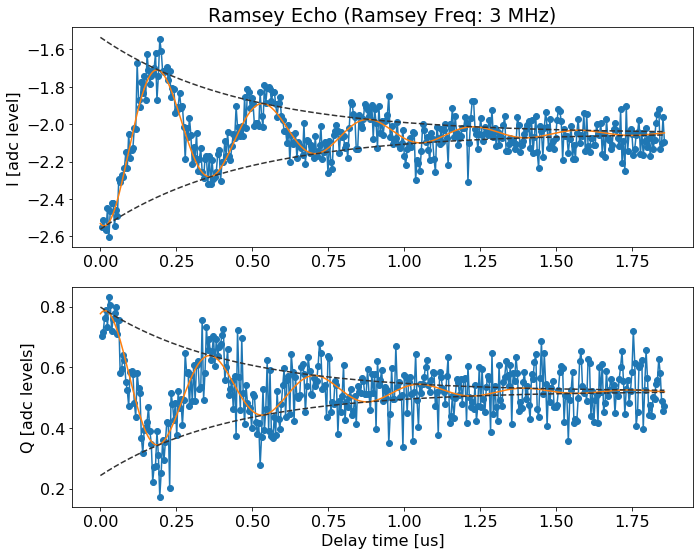

In [240]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = t2e.analyze(data=temp_data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [205]:
t2e.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00000_echo_qubit0.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [50]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 20
npts = 100

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=20, # Number of averages per point
    rounds=500, # Number of start to finish sweeps to average over
    length=0.5, # ef probe constant pulse length [us]
    gain=10000, # ef pulse gain
    qubit=qubit_i,
)

print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1], 'T1': [130, 45], 'f_ge': [3672.7788, 4565.7], 'f_ef': [3513.592, 4387.126], 'pulses': {'pi_ge': {'gain': [20522, 2012], 'sigma': [0.1, 0.05], 'type': 'gauss'}, 'pi_ef': {'gain': [7195, 1590], 'sigma': [0.3, 0.05], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1], 'adc': [0, 1], 'lo': ['readout', 'readout'], 'trig_offset': 250, 'frequency': [299.6865, 899.6655], 'gain': [60, 120], 'phase': [0, 0.49892147931760106], 'readout_length': 10, 'relax_delay': [600, 200]}}, 'hw': {'lo': {'readout': {'frequency': '6.25e9', 'power': 16}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [4, 5], 'nyquist': [2, 2]}, 'readout': {'ch': [7, 1], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 3503.592, 'step': 0.2, 'expts': 100, 'reps': 20, 'rounds': 500, 'length': 0.5, 'gain': 10000, 'qubit': 0}}


Found peak in avgi at [MHz] 3513.6251190162393, HWHM 1.055300883738679
Found peak in avgq at [MHz] 3513.5922842838236, HWHM 0.9850903029464015


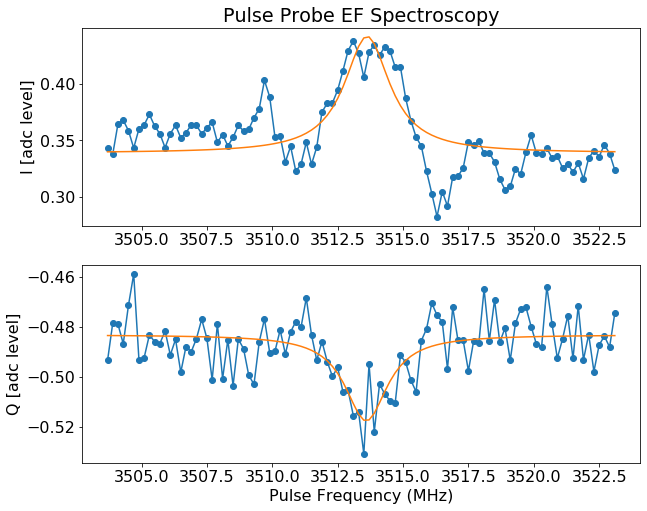

In [249]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True)
qEFspec.display(fit=True)

In [250]:
qEFspec.save_data()

Saving s:\Connie\experiments\20220202_2Transmon_Connie/data\00005_qubit_EF_spectroscopy_qubit0.h5


### Pulse probe EF power sweep

In [52]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1], 'T1': [130, 45], 'f_ge': [3672.7788, 4565.7], 'f_ef': [3513.592, 4387.126], 'pulses': {'pi_ge': {'gain': [20522, 2012], 'sigma': [0.1, 0.05], 'type': 'gauss'}, 'pi_ef': {'gain': [7195, 1590], 'sigma': [0.3, 0.05], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1], 'adc': [0, 1], 'lo': ['readout', 'readout'], 'trig_offset': 250, 'frequency': [299.6865, 899.6655], 'gain': [60, 120], 'phase': [0, 0.49892147931760106], 'readout_length': 10, 'relax_delay': 260}}, 'hw': {'lo': {'readout': {'frequency': '6.25e9', 'power': 16}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [4, 5], 'nyquist': [2, 2]}, 'readout': {'ch': [7, 1], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start_f': 297.1865, 'step_f': 1.0, 'expts_f': 5, 'start_gain': 1, 'step_gain': 500, 'expts_gain': 2, 'reps': 10, 'rounds': 10, 'length': 10, 'qubit': 0}}


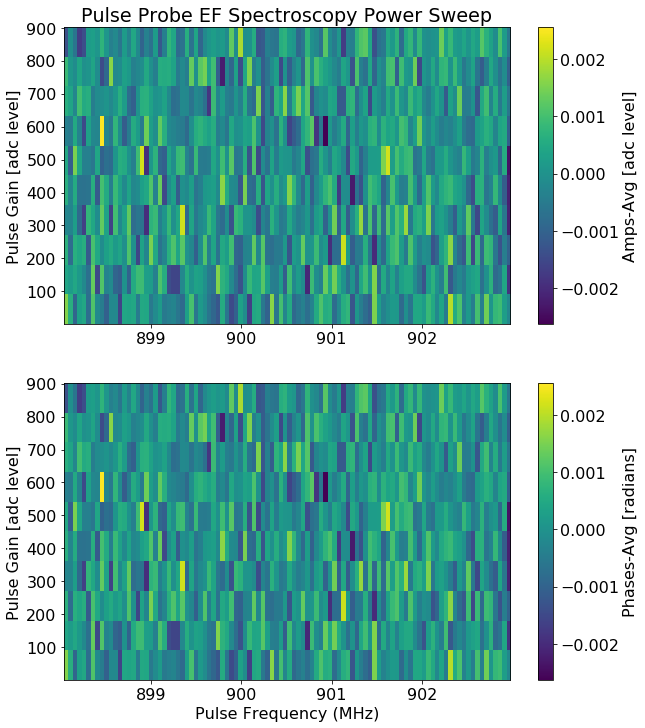

In [23]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

In [ ]:
rpowspec.save_data()

Saving s:\Connie\experiments\202201xx_2Transmon_Connie/data\00000_power_sweep_resonator_spectroscopy_qubit1.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [54]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 30000
npts = 5

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=10,
    rounds=10,
#     sigma_test=0.025, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1], 'T1': [130, 45], 'f_ge': [3672.7788, 4565.7], 'f_ef': [3513.592, 4387.126], 'pulses': {'pi_ge': {'gain': [20522, 2012], 'sigma': [0.1, 0.05], 'type': 'gauss'}, 'pi_ef': {'gain': [7195, 1590], 'sigma': [0.3, 0.05], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1], 'adc': [0, 1], 'lo': ['readout', 'readout'], 'trig_offset': 250, 'frequency': [299.6865, 899.6655], 'gain': [60, 120], 'phase': [0, 0.49892147931760106], 'readout_length': 10, 'relax_delay': [600, 200]}}, 'hw': {'lo': {'readout': {'frequency': '6.25e9', 'power': 16}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [4, 5], 'nyquist': [2, 2]}, 'readout': {'ch': [7, 1], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 1, 'step': 6000, 'expts': 5, 'reps': 10, 'rounds': 10, 'pulse_type': 'gauss', 'qubit': 0}}


Pi gain from amp [dac units]: 7195
Pi/2 gain from amp [dac units]: 3597

Pi gain from phase [dac units]: 771
Pi/2 gain from phase [dac units]: 385



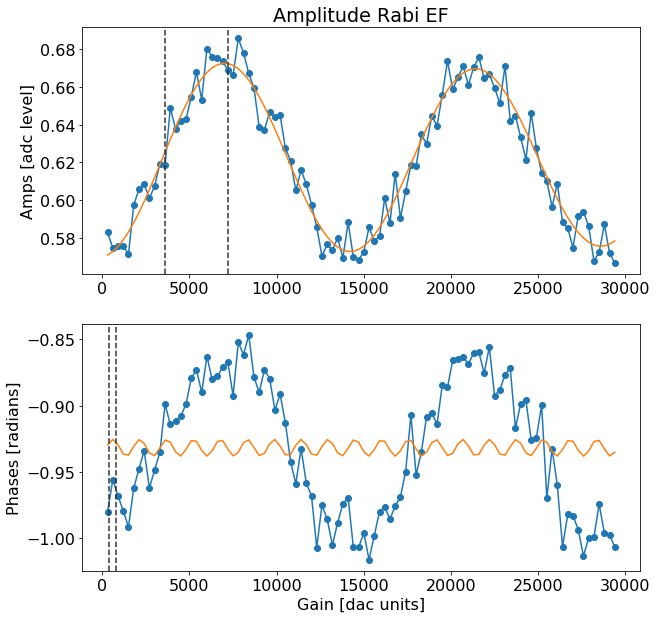

In [254]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [255]:
amprabiEF.save_data()

Saving s:\Connie\experiments\20220202_2Transmon_Connie/data\00001_amp_rabi_EF_qubit0.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [55]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=0.1, # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    expts=5,
    ramsey_freq=0.5, # [MHz]
    reps=10,
    rounds=10,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1], 'T1': [130, 45], 'f_ge': [3672.7788, 4565.7], 'f_ef': [3513.592, 4387.126], 'pulses': {'pi_ge': {'gain': [20522, 2012], 'sigma': [0.1, 0.05], 'type': 'gauss'}, 'pi_ef': {'gain': [7195, 1590], 'sigma': [0.3, 0.05], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1], 'adc': [0, 1], 'lo': ['readout', 'readout'], 'trig_offset': 250, 'frequency': [299.6865, 899.6655], 'gain': [60, 120], 'phase': [0, 0.49892147931760106], 'readout_length': 10, 'relax_delay': [600, 200]}}, 'hw': {'lo': {'readout': {'frequency': '6.25e9', 'power': 16}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [4, 5], 'nyquist': [2, 2]}, 'readout': {'ch': [7, 1], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 0, 'step': 0.1, 'expts': 5, 'ramsey_freq': 0.5, 'reps': 10, 'rounds': 10, 'qubit': 0}}


Suggested new qubit frequency from fit I [MHz]: 3513.7655903804603
T2 Ramsey from fit I: 17.500771594822435
Suggested new qubit frequency from fit Q [MHz]: 3512.4135877750773
T2 Ramsey from fit Q: 234.87071297063554


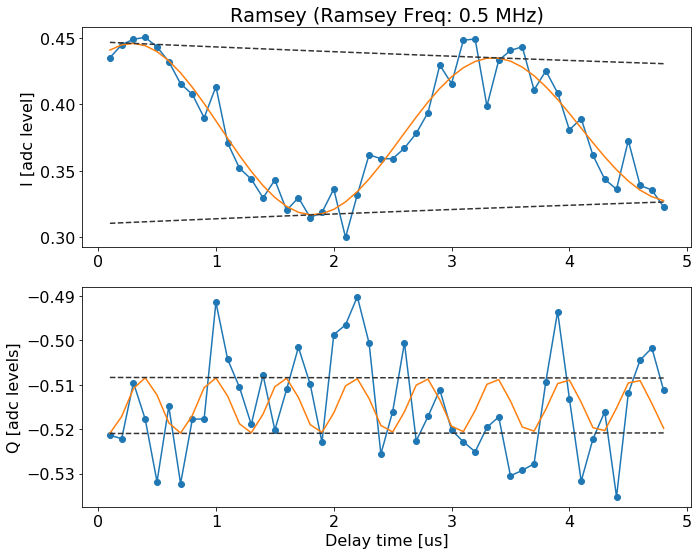

In [261]:
# # TESTING
# temp_data = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = t2EFr.analyze(data=temp_data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [262]:
t2EFr.save_data()

Saving s:\Connie\experiments\20220202_2Transmon_Connie/data\00000_ramseyEF_qubit0.h5
